In [2]:
from matplotlib import pyplot as plt
import numpy as np
import importlib

In [3]:
from simulator.ideal import SimulatorIdeal
from simulator.lennard import SimulatorLennard
from simulator.magnetic import SimulatorMagnetic

In [4]:
params = {
    "R" : 1.0,
    "Rz" : 0.01,
    "Bz" : 1.0,
    "eccentricity": 0.1,
    "energy": 1.0,
    "sigma":0.4,
    "sigma_grid":0.5,
    "position_random_shift_percentage": 0.0/100,
    "epsilon":1.0,
    "planar": False,
    "zero_momentum": True
}

In [5]:
sim = SimulatorMagnetic(**params)
# sim = SimulatorLennard(**params)
r_init, v_init = sim.init_positions_velocities(**params)
sim.particle_number()

21

In [6]:
# history = sim.to_array(sim.simulate(1, dt=1e-5, algorithm="EULER"))
# history = sim.to_array(sim.simulate(1, dt=1e-5, algorithm="RK"))
history = sim.to_array(sim.simulate(0.01, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))

100%|██████████| 1000/1000 [00:00<00:00, 2472.86it/s]


In [7]:
sim.start_time

datetime.datetime(2022, 7, 7, 16, 7, 10, 98232)

In [8]:
sim_id = sim.push_db()

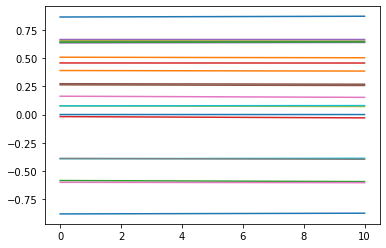

In [13]:
plt.plot(history["L"][:,2,:]);

Text(0.5, 1.0, 'Z Angular Momentum')

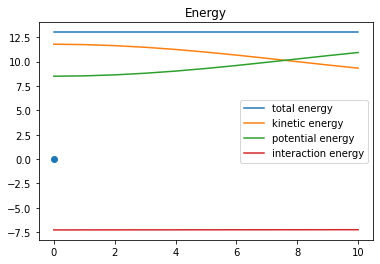

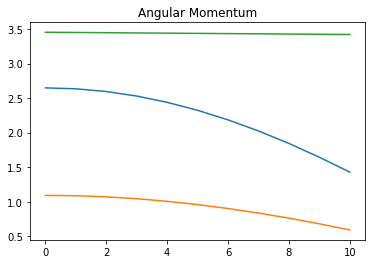

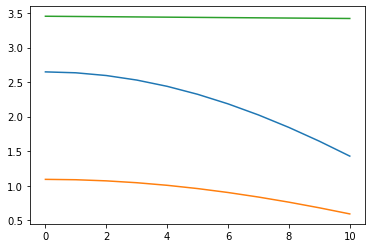

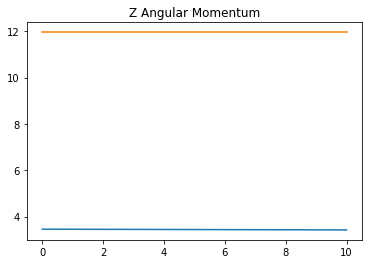

In [14]:
plt.figure()
plt.plot(np.sum(history["KE"] + history["PE"] + 0.5*history["IE"], axis=1), label="total energy")
plt.plot(np.sum(history["KE"], axis=1), label="kinetic energy")
plt.plot(np.sum(history["PE"], axis=1), label="potential energy")
plt.plot(0.5 * np.sum(history["IE"], axis=1), label="interaction energy")
plt.scatter(0,0)
plt.legend()
plt.title("Energy")

plt.figure()
plt.plot(np.sum(history["L"], axis=2))
plt.title("Angular Momentum")

plt.figure()
plt.plot(np.sum(history["L"], axis=2))

plt.figure()
plt.plot(np.sum(history["L"][:,2], axis=1))
plt.plot(np.sum(history["L"][:,2] + history["BInertia"], axis=1))
plt.scatter(0,0)
plt.title("Z Angular Momentum")


Text(0.5, 0, 'Z')

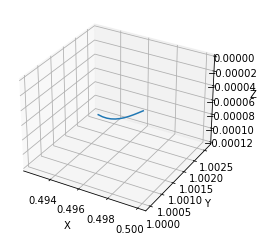

In [15]:
fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')
ax.set_aspect("auto")
pi = 20
rs = history["rs"]
ax.plot(rs[:,0,pi], rs[:,1,pi], rs[:,2,pi])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [16]:
import datetime
import time

In [17]:
datetime.datetime.now().strftime("%m-%d-%Y %H-%M-%S")

'07-07-2022 16-09-40'

In [19]:
sim = SimulatorMagnetic(**params)
init = sim.init_positions_velocities(**params)
history = sim.to_array(sim.simulate(0.03, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))

sim1 = SimulatorMagnetic(**params)
sim1.r_init, sim1.v_init = init
history1 = sim.to_array(sim1.simulate(0.01, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))
# history11 = sim.to_array(sim1.simulate(0.02, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))
id = sim1.push_db()

sim2 = SimulatorMagnetic()
sim2.load(id=id)
history2 = sim2.to_array(sim2.simulate(0.02, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))

np.equal(history2["rs"], history["rs"]).all()

100%|██████████| 2000/2000 [00:00<00:00, 3152.80it/s]


True

In [20]:
sim = SimulatorMagnetic(**params)
init = sim.init_positions_velocities(**params)

In [21]:
print(sim.angular_momentum(sim.r_init, sim.v_init)[2].sum())
sim.rotational_push(0.5)
print(sim.angular_momentum(sim.r_init, sim.v_init)[2].sum())


-0.1271323298485442
8.87213104758897
